# Mathematical Theory and Intuition behind Our Improved Model 

This markdown explains the mathematical theory behind our model. Note that the actual implementation might be different. For simplicity, we are also not including all the datasets we used (otherwise the equations might be too long).

Let $i$ denote the $i$th date since the beginning of our dataset and $n$ denote the cutoff date for training-testing . Let the range from $n+1$ to $m$ be the range for testing (forecast). 

For a given date $i$, let $\textbf{asp}(i)$ be the actual index for S\&P500; $\textbf{fbsp}(i)$ be the index for S\&P500 bases on a training set of the first $i-1$ many days' market data of S\&P500; $\textbf{div}(i)$ be the dividend yield rates of S\&P500; $\textbf{eps}(i)$ be the dividen yield rates of S\&P500; $\textbf{tby}(i)$ be the 10-year treasury bond yield; $\textbf{ffr}(i)$ be the fed fund rates;  $\textbf{fta}(i)$ be the fed total assets.

## Linear Model

\begin{equation}
    \textbf{fb}_1(i,a,b,c,d,e):=\textbf{fbsp}(i)+a*\textbf{tby}(i)+b*\textbf{ffr}(i)+c*\textbf{fta}(i)+d*\textbf{div}(i)+e*\textbf{eps}(i)
\end{equation}

\begin{equation}
    \textbf{E}_n(a,b,c,d,e):= \frac{1}{n-1000}\sum_{i=1000}^{n} 
    (\textbf{fb}_1(i,a,b,c,d,e)-\textbf{asp}(i))^2
\end{equation}

attains its minimum. Namely, finding

\begin{equation}
    (a_n,b_n,c_n,d_n,e_n):=\text{argmin} \textbf{E}_n(a,b,c,d,e)
\end{equation}

Note that it doesn't make sense to start with $i=1$ since the fbprophet itself need to use the first $i-1$ of the data for training

## Nonlinear Model

All notations are the same as above.

Here is a different model (nonlinear revision of fbprophet). In this model, we will the dividend yield rate of S\&P 500.

First, what is the dividend yield rate? Dividend is the money that publicly listed companies pay you (usually four times a year) for holding their stocks (until the so-called ex-dividend dates). It's like the interest paid to your saving accounts from the banks. Some companies pay while some don't, especially for the growth tech stocks. From my experience, the impact of bond rates and fed fund rates on the stock market will change when they rise above or fall below the dividend yield rate}. Stock prices fall when those rates rise above the dividend yield rate of SP500 (investor are selling their stocks to buy bonds or save more money in their bank account!).

Based on this idea, it might be useful to consider the differences of those rates and the dividend yield rate of SP500. 

Normally an increase in the federal fund rate will result in an increase in bank loan interest rate, which will in turn result in an decrease in the net income of S\&P500-listed companies since they have to pay a higher interest when borrowing money from banks. Based on this thought, I believe it is reasonable to make a correction to $c*\textbf{eps}(i)$ by replacing the term by $c*\textbf{eps}(i)(1+d*\textbf{ffr}(i))$. If my intuition is correct, the generated constant $d$ from the optimization should be a negative number. 


$$\textbf{fb}_2(i,a,b,c,d,e):= \textbf{fbsp}(i)*\big[1+a*(\textbf{div}(i)-\textbf{tby}(i))\big]\big[1+b*(\textbf{div}(i)-\textbf{ffr}(i))\big]\\
+c*\textbf{eps}(i)(1+d*\textbf{ffr}(i)+e*\textbf{fta}(i))$$

and consider

$$E_n(a,b,c,d,e) := \frac{1}{n-1000}\sum_{i=1000}^n(\textbf{fb}_2(i,a,b,c,d,e)-\textbf{asp}(i))^2$$

Now find (by approximation, SGD, etc.) $(a_n,b_n,c_n,d_n,e_n):=\text{argmin} E_n(a,b,c,d,e)$ 

Using $(a_n,b_n,c_n,d_n,e_n)$ as constants, our output will be $\textbf{fb}_2(i,a_n,b_n,c_n,d_n,e_n)$


### The actual implementation of the nonlinear model

For the actual implementation of the nonlinear model, we threw away the higher order terms (the products of three things) since they are relatively smaller quantities

### The mathematical theory behind our nonlinear model: 

#### The Taylor's theorem for multivariate functions

Let $f :\mathbb{R}^n → \mathbb R$ be a $k$-times-differentiable function at the point $a ∈ \mathbb{R}^n$. Then there exists $h_a:\mathbb{R}^n → \mathbb R$ such that:

<math>\begin{align}
& f(\boldsymbol{x}) = \sum_{|\alpha|\leq k} \frac{D^\alpha f(\boldsymbol{a})}{\alpha!} (\boldsymbol{x}-\boldsymbol{a})^\alpha  + \sum_{|\alpha|=k} h_\alpha(\boldsymbol{x})(\boldsymbol{x}-\boldsymbol{a})^\alpha, \\
& \mbox{and}\quad \lim_{\boldsymbol{x}\to \boldsymbol{a}}h_\alpha(\boldsymbol{x})=0.
\end{align}</math>

In our model, we think of $\textbf{asp}$ as a function of $\textbf{fbsp}, \textbf{tby}, \textbf{div}, \textbf{ffr}, \textbf{fta}$, etc. Say 

$$\textbf{asp}:=F(\textbf{fbsp}, \textbf{tby}, \textbf{div}, \textbf{ffr}, \textbf{fta},\cdots)$$

With the assumption that $F$ here is regular, we can apply the Taylor's theorem for multivariate functions from above to $F$. Ideally, we have to consider all possible products in our implementation. But in our implementation, we chose to make a balance between our intuitive nonlinear model and Taylor's theorem.

## A faster computation scheme
One drawback of the models we proposed about is that we have to call fbprophet thousands of times when we implement it.

Here is a method that reduces the number of times calling fbprophet:

Say in the training process we are considering from i=1,000 to 11,000. Namely based on the current scheme, we have to call fbprophet for 10,000 times.

Instead of this, we make a break-down 10,000=100*100 as follows:

For i=1,000 to 1,100, we only use the first 999 dates for training;

For i=1,100 to 1,200, we only use the first 1,099 dates for training;

.............................................

For i=10,900 to 11,000, we only use the first 10,899 dates for training;

In this way, it seems that we only need to call fbprophet for 100 times. And this doesn't seem harm the accuracy too much.

In [1]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
path = '../Data/dff1.csv'

In [3]:
df= pd.read_csv(path, parse_dates=['ds'])
# df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df = df[['ds', 'y','fbsp', 'diff','tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi',
       'rfs']]
# df

In [4]:
df['fbsp_tby'] = df['fbsp'] * df['tby']
df['fbsp_ffr'] = df['fbsp'] * df['ffr']
df['fbsp_div'] = df['fbsp'] * df['div']
df['eps_tby'] = df['eps'] * df['tby']
df['eps_ffr'] = df['eps'] * df['ffr']
df['eps_div'] = df['eps'] * df['div']

In [5]:
# cutoff between test and train data
cutoff = len(df) - 252
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()
print(cutoff)

2300


In [6]:
df_train.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
       'eps_ffr', 'eps_div'],
      dtype='object')

In [12]:
#possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti',
#      'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
#      'eps_ffr', 'eps_div']

possible_features = ['tby', 'ffr', 'fta', 'div', 'une', 
      'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div']

from itertools import chain, combinations

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#print(list(powerset(possible_features)))

In [13]:
len(possible_features)

10

In [14]:
from statsmodels.regression.linear_model import OLS

reg_new = OLS((df_train['diff']).copy(),df_train[possible_features].copy()).fit()
print(reg_new.params)

#from the output, we can see it's consistent with sklearn output

tby         142.277390
ffr          85.508342
fta           0.000068
div         366.196032
une        -139.915289
ppi          -0.651339
rfs           0.003782
fbsp_tby     -0.060019
fbsp_ffr      0.017499
fbsp_div     -0.462135
dtype: float64


In [15]:
new_coef = reg_new.params
new_possible_feats = new_coef[abs(new_coef)>0].index

power_feats = list(powerset(new_possible_feats))
power_feats.remove(())

power_feats = [ list(feats) for feats in power_feats]
len(power_feats)


1023

In [16]:
AIC_scores = []
parameters = []

for feats in power_feats:
    tmp_reg = OLS((df_train['diff']).copy(),df_train[feats].copy()).fit()
    AIC_scores.append(tmp_reg.aic)
    parameters.append(tmp_reg.params)

    
Min_AIC_index = AIC_scores.index(min(AIC_scores))
Min_AIC_feats = power_feats[Min_AIC_index]  
Min_AIC_params  = parameters[Min_AIC_index]
print(Min_AIC_feats)
print(Min_AIC_params)  

['tby', 'ffr', 'fta', 'div', 'une', 'rfs', 'fbsp_tby', 'fbsp_div']
tby         151.672502
ffr         133.514484
fta           0.000063
div         359.410771
une        -144.152409
rfs           0.003479
fbsp_tby     -0.064792
fbsp_div     -0.447041
dtype: float64


In [17]:
len(Min_AIC_feats)

8

In [18]:
###After selecting the best features, we report the testing error, and make the plot 
AIC_df_test = df_test[Min_AIC_feats]
AIC_pred_test = AIC_df_test.dot(Min_AIC_params)+df_test.fbsp

AIC_df_train = df_train[Min_AIC_feats]
AIC_pred_train = AIC_df_train.dot(Min_AIC_params)+ df_train.fbsp



In [19]:
from sklearn.metrics import mean_squared_error as MSE

mse_train = MSE(df_train.y, AIC_pred_train) 
mse_test = MSE(df_test.y, AIC_pred_test)


#compare with fbprophet()

fb_mse_train = MSE(df_train.y, df_train.fbsp) 
fb_mse_test = MSE(df_test.y, df_test.fbsp)


print(mse_train,fb_mse_train)

print(mse_test,fb_mse_test)

3021.3722993387496 22303.56360854362
39273.94024676501 15247.912341091065


In [20]:
df_train.ds

0      2009-12-15
1      2009-12-16
2      2009-12-17
3      2009-12-18
4      2009-12-21
          ...    
2295   2019-02-20
2296   2019-02-21
2297   2019-02-22
2298   2019-02-25
2299   2019-02-26
Name: ds, Length: 2300, dtype: datetime64[ns]

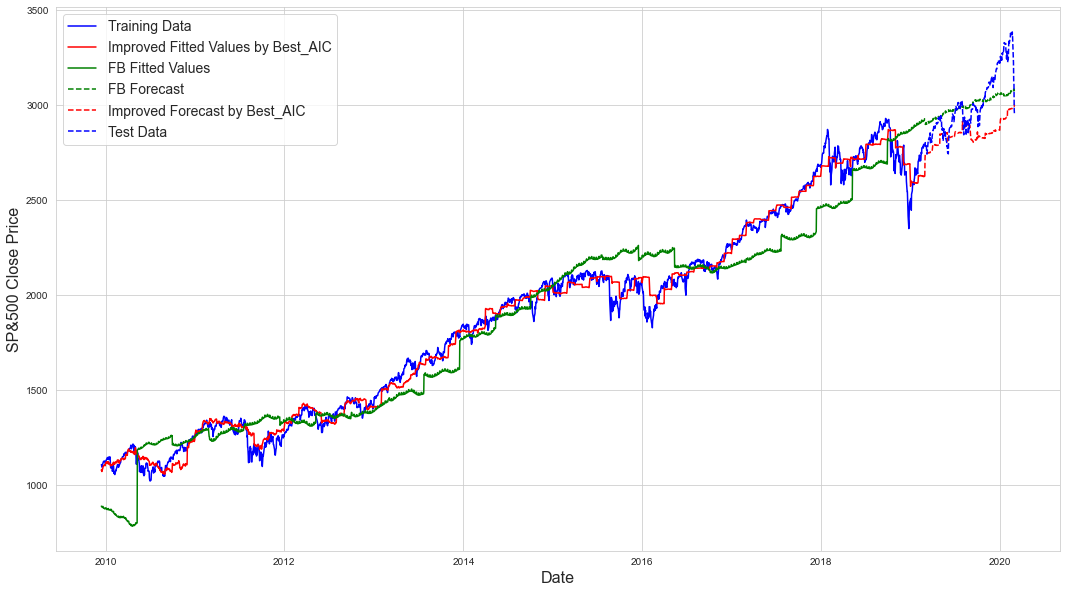

In [21]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds, AIC_pred_train,'r-',
            label = "Improved Fitted Values by Best_AIC")

# # plot the fit
plt.plot(df_train.ds, df_train.fbsp,'g-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test.ds, df_test.fbsp,'g--',
            label = "FB Forecast")
plt.plot(df_test.ds, AIC_pred_test,'r--',
            label = "Improved Forecast by Best_AIC")
plt.plot(df_test.ds,df_test.y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(df_test.y,label="Training Data")
plt.plot(df_test.fbsp,label="FB Forecast")
plt.plot(AIC_pred_test,label="Improved Forecast by Best_AIC")
plt.legend(fontsize = 14)
plt.show()

In [18]:
column = ['tby', 'ffr', 'fta', 'eps', 'div', 'une',
                                                  'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div']

In [19]:
from sklearn import preprocessing
df1_train = df_train[['diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div']]

X = preprocessing.scale(df1_train)
from statsmodels.regression.linear_model import OLS

reg_new = OLS((X[:,0]).copy(),X[:,1:].copy()).fit()
print(reg_new.params)

[ 1.50405129  1.03228322  0.27409454  1.17073571  0.31243092 -0.75747342
  0.46988206 -0.39944639  2.10369448 -0.69112943 -2.1804296  -2.38576385
 -1.14196633  1.41832903 -0.34501927]


In [20]:
# Before Covid
# pd.Series(reg_new.params, index=['tby', 'ffr', 'fta', 'eps', 'div', 'une',
#                                                   'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div'] )

In [21]:
# before covid
coef1 = [ 1.50405129,  1.03228322,  0.27409454,  1.17073571,  0.31243092,
       -0.75747342,  0.46988206, -0.39944639,  2.10369448, -0.69112943,
       -2.1804296 , -2.38576385, -1.14196633,  1.41832903, -0.34501927]
# include covid
coef2 = [ 0.65150054,  1.70457239, -0.1573802 , -0.18007979, -0.15221931,
       -0.62326075,  0.45065894, -0.38972706,  2.87210843, -1.17604495,
       -4.92858316, -2.15459111,  0.11418468,  2.74829778,  0.55520382]

In [22]:
# Include Covid
# pd.Series( np.append( ['coefficients (before covid)'], np.round(coef1,3)),  index= np.append(['features'], column) ) 
                                        

In [26]:
index1 = ['10 Year U.S Treasury Bond Yield Rates (tby)', 'Federal Funds Rates (ffr)',
        'Federal Total Assets (fta)', 'Earning-Per-Share of S&P 500 (eps)', 'Dividend Yield of S&P 500 (div)',
        'Unemployment Rates (une) ', 'West Texas Intermediate oil index (wit)', 'Producer Price Index (ppi)',
         'Retail and Food Services Sales (rfs)', 
         'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div'
        ]

In [27]:
len(index1)

15

In [28]:
pd.Series(coef2, index =index1)

10 Year U.S Treasury Bond Yield Rates (tby)    0.651501
Federal Funds Rates (ffr)                      1.704572
Federal Total Assets (fta)                    -0.157380
Earning-Per-Share of S&P 500 (eps)            -0.180080
Dividend Yield of S&P 500 (div)               -0.152219
Unemployment Rates (une)                      -0.623261
West Texas Intermediate oil index (wit)        0.450659
Producer Price Index (ppi)                    -0.389727
Retail and Food Services Sales (rfs)           2.872108
fbsp_tby                                      -1.176045
fbsp_ffr                                      -4.928583
fbsp_div                                      -2.154591
eps_tby                                        0.114185
eps_ffr                                        2.748298
eps_div                                        0.555204
dtype: float64

In [29]:
df3 = pd.DataFrame(coef1, index = index1, columns = ['coefficients (before covid)'])
df3['coefficients (include covid)'] =pd.Series(coef2, index =index1)
df3

,coefficients (before covid),coefficients (include covid)
10 Year U.S Treasury Bond Yield Rates (tby),1.504051,0.651501
Federal Funds Rates (ffr),1.032283,1.704572
Federal Total Assets (fta),0.274095,-0.157380
Earning-Per-Share of S&P 500 (eps),1.170736,-0.180080
Dividend Yield of S&P 500 (div),0.312431,-0.152219
Unemployment Rates (une),-0.757473,-0.623261
West Texas Intermediate oil index (wit),0.469882,0.450659
Producer Price Index (ppi),-0.399446,-0.389727
Retail and Food Services Sales (rfs),2.103694,2.872108
fbsp_tby,-0.691129,-1.176045
